In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.api as sm

In [3]:
import io
import datetime
import urllib.request

# Seasonal Decomposition

## Trial Data

We use the well known [Mauna Loa Carbon Dioxide dataset][1]. Following function fetch the file from ftp:

[1]: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt

In [4]:
def to_dataframe(fname=None):
    """
    Read Moana Loa CO2 FWF Source File:
    """
    if fname is None:
        uri = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt'
        with urllib.request.urlopen(uri) as response:
            lines = response.read().decode().split("\n")
        with open("CO2_{:%Y%m%d}.txt".format(datetime.datetime.utcnow()), 'w') as file:
            file.write("\n".join(lines))
    else:
        with open(fname) as file:
            lines = map(str.strip, file.readlines())
    stream = io.StringIO("\n".join(filter(lambda x: not(x.startswith('#')), lines)))
    df = pd.read_fwf(
        stream,
        header=None, usecols=[0, 1, 2, 4, 5],
        names=['year', 'month', 'day', 'value', 'ndays'],
        parse_dates={'timestamp': ['year', 'month', 'day']},
        index_col='timestamp',
        na_values=[-999.99]
    )
    return df

In [5]:
df = to_dataframe('co2_weekly_mlo.txt').interpolate(mode='time')
df.head()

,value,ndays
timestamp,,
1974-05-19,333.34,6
1974-05-26,332.95,6
1974-06-02,332.32,5
1974-06-09,332.18,7
1974-06-16,332.37,7


Plotting data shows up the CO2 trend:

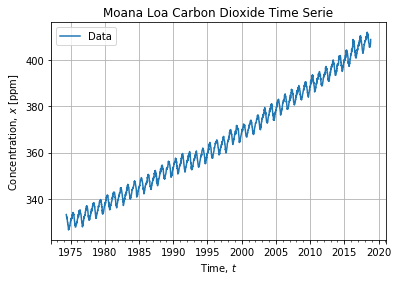

In [6]:
axe = df['value'].plot(label='Data')
axe.set_title('Moana Loa Carbon Dioxide Time Serie')
axe.set_xlabel('Time, $t$')
axe.set_ylabel('Concentration, $x$ $[\mathrm{ppm}]$')
axe.grid()
axe.legend()

## ARIMA

 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.fit.html#statsmodels.tsa.arima_model.ARIMA.fit
 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html#statsmodels.tsa.arima_model.ARIMAResults

In [7]:
x = df.loc[:,"value"].resample('MS').agg(['mean', 'std', 'count'])
x.head()

,mean,std,count
timestamp,,,
1974-05-01,333.1450,0.275772,2
1974-06-01,332.0280,0.366838,5
1974-07-01,330.7125,0.678988,4
1974-08-01,329.0725,0.620880,4
1974-09-01,327.3240,0.517958,5


In [8]:
model = sm.tsa.statespace.SARIMAX(
    x['mean'],
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    #enforce_stationarity=False,
    #enforce_invertibility=False
    #mle_regression=True
)
result = model.fit()

In [9]:
result.aic

313.477759393627

In [10]:
result.params

ar.L1       0.999934
ma.L1      -0.454097
ma.S.L12   -0.874141
sigma2      0.100838
dtype: float64

In [11]:
pred = result.get_prediction(start='2010-01-01')

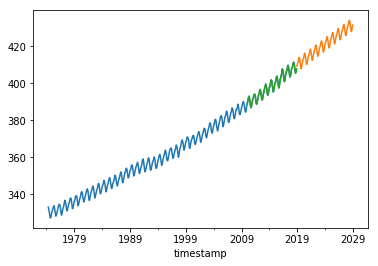

In [12]:
axe = x["mean"].plot()
result.forecast(10*12+1).plot(ax=axe)
pred.predicted_mean.plot(ax=axe)

 - http://www.statsmodels.org/dev/examples/
 - https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

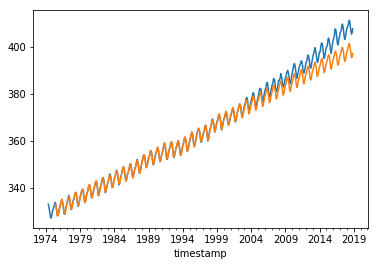

In [13]:
axe = x["mean"].plot()
result.predict(dynamic='2000-01-01').loc['1975-05-01':].plot(ax=axe)

In [14]:
result.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 12,
 'reduced_ar': 1,
 'reduced_ma': 13,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [15]:
result.pvalues

ar.L1       0.000000e+00
ma.L1       8.847806e-41
ma.S.L12    0.000000e+00
sigma2      4.303133e-84
dtype: float64

In [16]:
result.params

ar.L1       0.999934
ma.L1      -0.454097
ma.S.L12   -0.874141
sigma2      0.100838
dtype: float64

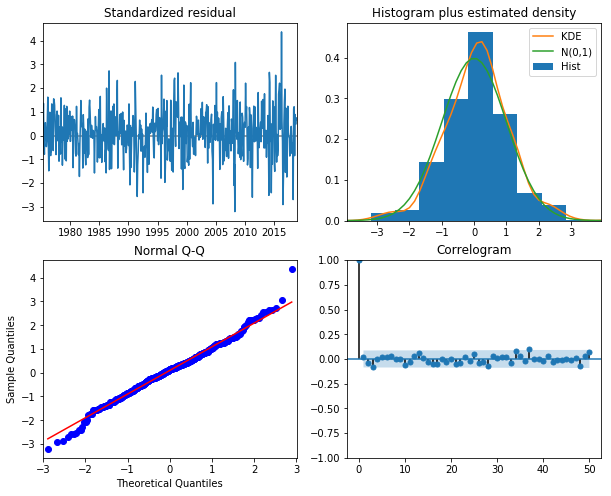

In [17]:
_ = result.plot_diagnostics(lags=50, figsize=(10,8))